In [1]:
import yaml
import sys
sys.path.append("../")
from plugins.interfaces.diagnostics import AWAFrameGrabberDiagnostic, ROI

# define screen and trim parameters
screen = "DYG5"
magnet_info = yaml.safe_load(open("awa_config/awa_drive_magnet_config.yml"))
screen_info = yaml.safe_load(open("awa_config/awa_drive_camera_config.yml"))[screen]

In [2]:
# create Xopt objects
from xopt import VOCS
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
        }

vocs = VOCS(
    variables = {magnet_info[name]["PV"]:magnet_info[name]["RANGE"] for name in ["DT8H","DQ4"]
    },
    observables = ["center_dist","Cx","Cy"],
    constraints=IMAGE_CONSTRAINTS
)

In [3]:
vocs

VOCS(variables={'AWA:Drive:DT8H_B_S:Ctrl': [-2.0, 2.0], 'AWA:Bira3Ctrl:Ch03': [-1.0, 1.0]}, constraints={'bb_penalty': ['LESS_THAN', 0.0]}, objectives={}, constants={}, observables=['center_dist', 'Cx', 'Cy'])

In [4]:
screen_roi = ROI(
    xcenter=int(screen_info["center"][0]),
    ycenter=int(screen_info["center"][1]),
    xwidth=int(screen_info["radius"]*1.5),
    ywidth=int(screen_info["radius"]*1.5),
)

image_diagnostic = AWAFrameGrabberDiagnostic(
    roi=screen_roi, apply_bounding_box_constraint=False, visualize=False
)

displaying image
fitting image


{'Cx': 272.55842977092635,
 'Cy': 151.1627141063503,
 'Sx': 14.625259777755057,
 'Sy': 14.76473417087176,
 'bb_penalty': -154.90384120007423,
 'total_intensity': 6747441.0,
 'log10_total_intensity': 6.829139095750013}

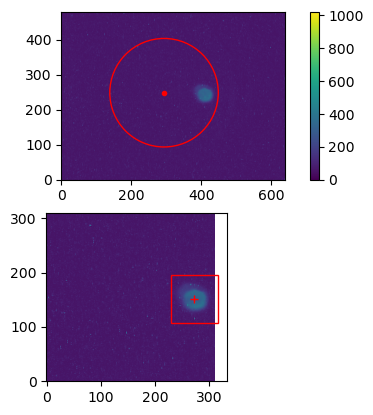

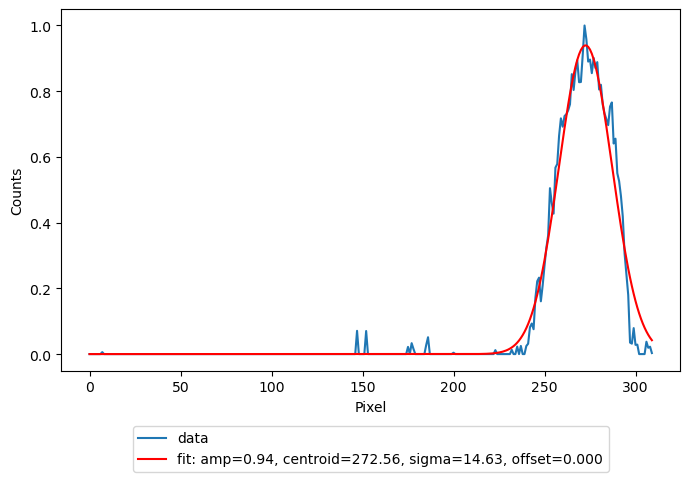

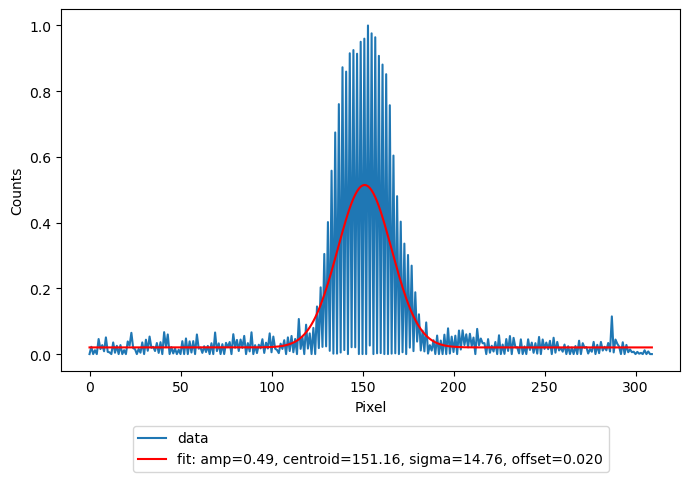

In [5]:
image_diagnostic.test_measurement()

In [6]:
import time
from xopt import Evaluator
from epics import caput

def evaluate(inputs: dict):
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(1.0)

    results = image_diagnostic.measure_beamsize(1, **inputs)

    # measure distance to image center
    print(results["Cx"], image_diagnostic.roi.xwidth/2)
    results["center_dist_x"] = results["Cx"] - image_diagnostic.roi.xwidth/2
    results["center_dist_y"] = results["Cy"] - image_diagnostic.roi.ywidth/2

    results["center_dist"] = (results["center_dist_x"]**2 + results["center_dist_y"]**2)**0.5
    results["time"] = time.time()
    
    return results

evaluator = Evaluator(function=evaluate)

In [7]:
from xopt.generators import get_generator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = get_generator("bayesian_exploration")(
    vocs=vocs, gp_constructor=model_constructor, 
    n_interpolate_points=5, 
)
generator.numerical_optimizer.max_time = 10.0

In [8]:
from xopt import Xopt
dump_filename = "quad_misalignment_DT7_good.yml"
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, dump_file=dump_filename)

In [9]:
X


            Xopt
________________________________
Version: 2.1.0+27.g53bd9d64.dirty
Data size: 0
Config as YAML:
dump_file: quad_misalignment_DT7_good.yml
evaluator:
  function: __main__.evaluate
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: false
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: 5
  n_monte_carlo_samples: 128
  name: bayesian_exploration
  numerical_optimizer:
    max_iter: 2000
    max_time: 10.0
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints:
    bb_penalty:
    - LESS_THAN
    - 0.0
  objectives: {}
  obse

In [10]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd
import numpy as np
current_value = dict(zip(X.vocs.variable_names, caget_many(X.vocs.variable_names)))
print(current_value)
# get small region around current point to sample
random_sample_region = get_local_region(current_value,X.vocs, fraction=0.5)

# create a mesh
xx = np.meshgrid(
    np.linspace(-0.66,0,5),
    np.linspace(-1.1,1.1,5)
)
pts = np.vstack([ele.flatten() for ele in xx])

X.evaluate_data({"AWA:Bira3Ctrl:Ch03":pts[0],"AWA:Drive:DT8H_B_S:Ctrl":pts[1]})


#X.random_evaluate(4, custom_bounds=random_sample_region)

{'AWA:Bira3Ctrl:Ch03': 0.0, 'AWA:Drive:DT8H_B_S:Ctrl': 1.1}


CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:51190, Ignored: 192.168.0.2:51190"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Feb 27 2024 10:17:48.456177381
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:51190, Ignored: awa3.hep.anl.gov:51190"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Feb 27 2024 10:17:48.457155902
..................................................................


fitting image
73.54337746243824 155.0
fitting image
62.210172808529656 155.0
fitting image
49.98064573013355 155.0
fitting image
40.11410917230688 155.0
fitting image
28.13804424718891 155.0
fitting image
112.91249674035313 155.0
fitting image
108.9240521190983 155.0
fitting image
102.4518573106858 155.0
fitting image
95.55431238548258 155.0
fitting image
89.88596880661444 155.0
fitting image
153.7341848136593 155.0
fitting image
151.93408189438574 155.0
fitting image
150.81634487816535 155.0
fitting image
150.30116690773443 155.0
fitting image
148.43598832822113 155.0
fitting image
192.78757444758207 155.0
fitting image
196.9735497334327 155.0
fitting image
201.55649812566443 155.0
fitting image
204.7956092585081 155.0
fitting image
208.8601526272375 155.0
fitting image
233.59932066818135 155.0
fitting image
241.36750783822708 155.0
fitting image
251.64624881183923 155.0
fitting image
262.54966057057726 155.0
fitting image
270.5177231598415 155.0


,AWA:Bira3Ctrl:Ch03,AWA:Drive:DT8H_B_S:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,-0.660,-1.10,73.543377,120.690912,4.532148,28.966436,6.542206,6545582.0,6.815948,-81.456623,-34.309088,88.387187,1.709051e+09,2.262799,False
1,-0.495,-1.10,62.210173,125.538206,5.941283,25.105879,7.687681,6697716.0,6.825927,-92.789827,-29.461794,97.354760,1.709051e+09,2.618546,False
2,-0.330,-1.10,49.980646,134.134365,9.091777,19.431148,10.465234,6689909.0,6.825420,-105.019354,-20.865635,107.072123,1.709051e+09,2.258875,False
3,-0.165,-1.10,40.114109,141.161242,12.184311,17.483647,20.375607,6735889.0,6.828395,-114.885891,-13.838758,115.716374,1.709051e+09,2.233097,False
4,0.000,-1.10,28.138044,149.503508,16.275726,13.474936,33.074336,6752782.0,6.829483,-126.861956,-5.496492,126.980972,1.709051e+09,2.339674,False
5,-0.660,-0.55,112.912497,124.094321,4.522250,29.429479,-22.722586,6549847.0,6.816231,-42.087503,-30.905679,52.216079,1.709051e+09,2.549866,False
6,-0.495,-0.55,108.924052,123.850507,5.492422,28.645833,-19.555278,6775073.0,6.830914,-46.075948,-31.149493,55.617299,1.709051e+09,2.374995,False
7,-0.330,-0.55,102.451857,133.788643,9.526248,24.196174,-22.057666,6865602.0,6.836679,-52.548143,-21.211357,56.667706,1.709051e+09,2.413400,False
8,-0.165,-0.55,95.554312,141.510766,12.535715,17.768705,-25.774055,6805239.0,6.832843,-59.445688,-13.489234,60.956946,1.709051e+09,2.446380,False
9,0.000,-0.55,89.885969,148.807289,15.209151,13.736914,-24.368324,6762899.0,6.830133,-65.114031,-6.192711,65.407849,1.709051e+09,2.389837,False


In [11]:
X.generator.train_model()

ModelListGP(
  (models): ModuleList(
    (0-3): 4 x SingleTaskGP(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): MaternKernel(
          (lengthscale_prior): GammaPrior()
          (raw_lengthscale_constraint): Positive()
        )
        (outputscale_prior): GammaPrior()
        (raw_outputscale_constraint): Positive()
      )
      (outcome_transform): Standardize()
      (input_transform): Normalize()
    )
  )
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-3): 4 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
)

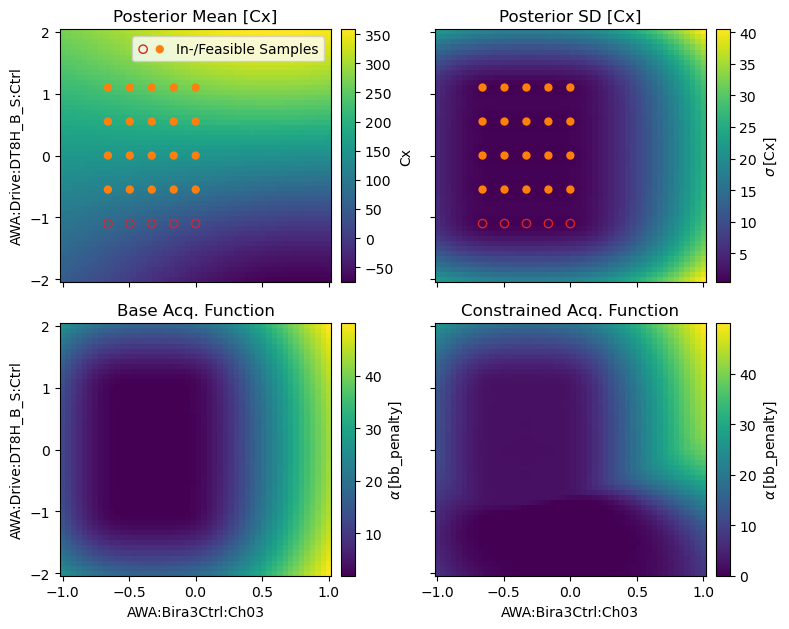

In [12]:
from xopt.generators.bayesian.visualize import visualize_generator_model
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)

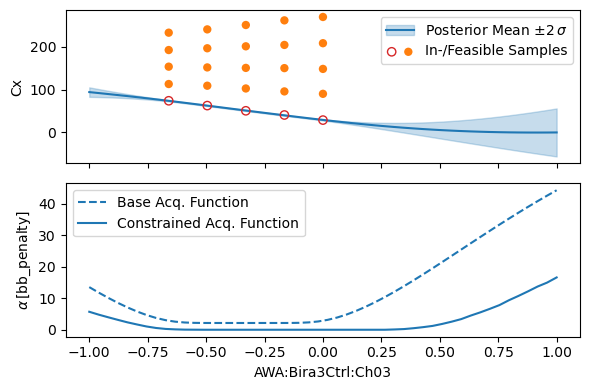

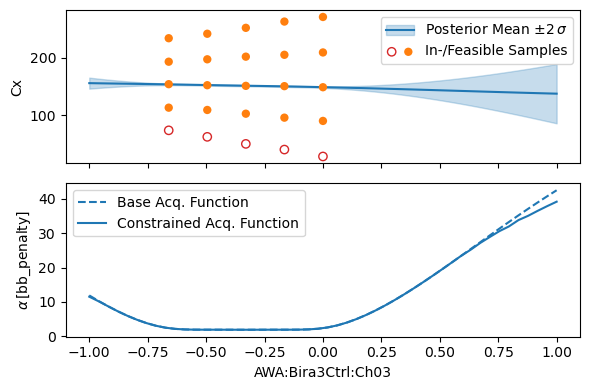

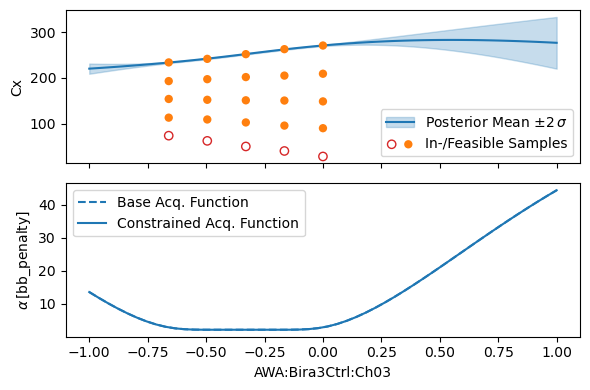

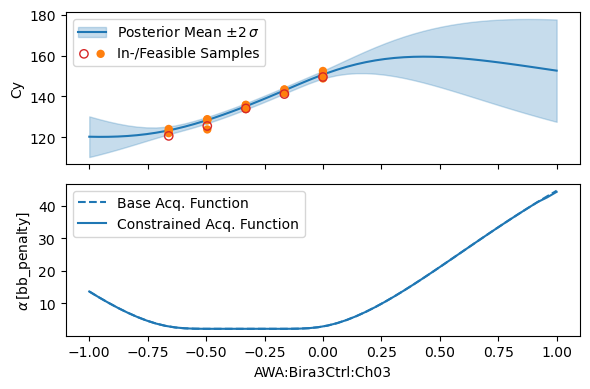

In [15]:
from xopt.generators.bayesian.visualize import visualize_generator_model

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":-1.1},
    output_names=["Cx"]
)

fig2,ax2 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.0},
    output_names=["Cx"]
)

fig3,ax3 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cx"]
)

fig4,ax4 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cy"]
)
